I recently started playing around with astrophotography. I don't have any specialized astro equipment - I'm just using my Fuji X-T3 and a couple prime lenses.

There are a couple interesting challenges when it comes to astrophotography. One is noise; when you're taking pictures of something that's mostly black, noise starts to become a primary concern. The other is the fact that the sky isn't a cooperative subject - it tends to move (slowly, inexorably) as you're trying to photograph it. I'll talk about both of those things here.

This whole page is a Jupyter python 3 notebook. [You can download this notebook (and my astrophotography scripts) here](https://github.com/wyager/astro).

## Tracking the Sky

Because the sky is so dark, one often wants to take long-exposure photographs of it. The problem, of course, is that the earth is rotating, so from the perspective of a stationary camera, the stars keep moving. On the scale of a few seconds of exposure, the stars begin to make obvious "streaks" across the sky. This can be cool stylistically, but if you want to take a sharp image of the sky, this is a problem.

A lot of more serious astrophotographers will use some kind of motorized sky-tracking mount so that the camera physically rotates against the earth's rotation, so the stars appear to stay in the same place. I'm not invested enough to get a setup like that yet, but thankfully we can sort of simulate sky-tracking in software.

The trick is to take a bunch of short-exposure shots, where the camera is not exposing long enough for the stars' movement to become apparent. Then, we can combine these short-exposure shots in software, cropping or rotating shots as necessary so that they line up. The end result is almost (but not quite) like a single long-exposure photograph with sky tracking.

There are a number of existing software tools for doing this (the most popular is, annoyingly, Windows-only), but I wanted to whip up something I understood fully and could tweak as needed.

The first step is to convert the RAW images from my camera to something I can easily manipulate in software. MacOS comes with a command line tool called `sips` that can convert between RAW and TIFF formats. TIFF is lossless and supported by many software libraries, including the Python libraries I'm using. I have a [quick bash script](https://github.com/wyager/astro/blob/master/convert.sh) to convert a bunch of Fuji RAW images to TIFF, prepending the filename with some info about ISO/exposure time/aperture. There are similar tools available for Linux, like `ufraw`. 


After I've converted my RAW photos to TIFF, I have [a python script](https://github.com/wyager/astro/blob/master/combine.py) that analyzes the TIFF files and overlays them on top of each other. The meat of the script is:

In [17]:
import numpy as np
import imageio
import cv2
import sys

# compute a homography (3x3 transform matrix for 2D homogenous coordinates)
# that projects image 1 onto image 2. We use this to line up multiple images
# of the sky that were taken at different times, with the camera at a slightly
# different angle, etc.
def match(im1,im2):
    # OpenCV ORB requires uint8 for some reason
    im1 = (im1*256).astype('uint8') 
    im2 = (im2*256).astype('uint8')
    # Identify interesting points in the image (i.e. stars)
    det = cv2.ORB_create(nfeatures=50000)
    kp1,desc1 = det.detectAndCompute(im1,None)
    kp2,desc2 = det.detectAndCompute(im2,None)
    # Matches up interesting points in both images, based on their descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
    matches = bf.match(desc1,desc2)
    # Pick the top 10% of matches (by hamming distance of their descriptor vectors)
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:len(matches)//10]
    if len(matches) < 10:
        raise Exception("<10 matching descriptors, poor match")
    # Get the coordinates of the matching stars in each image
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    # Calculate a homography matrix from our set of probably-matching stars.
    # The RANSAC algorithm will try to discard inconsistent outliers.
    # Mask tells us which matches seem internally consistent.
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    if mask.sum() < 10:
        raise Exception("<10 RANSAC inlier descriptors, poor match")
    return M

# Using `im` as the canvas, project every image in `loaders` onto `im` (after lining them up).
# Returns the summed up image, as well as an array telling us what fraction of images contributed
# to each pixel. We probably only want to use pixels that came from every image
# We use `loaders` instead of passing in images directly because we want to 
# load huge TIFF images into memory one at a time rather than all at once.
def add(im,loaders):
    (h,w,_) = im.shape
    out = im.copy()
    count = np.full((h,w),1.0)
    for load_im2 in loaders:
        im2 = load_im2()
        M = match(im2,im)
        out += cv2.warpPerspective(im2,M,(w,h))
        counter = np.full(im2.shape[0:2],1.0)
        count += cv2.warpPerspective(counter,M,(w,h))
    return (out/out.max(),count/count.max())
 
# Normalize various formats to [0,1)       
maxima = { np.uint8 : 255.0
         , np.dtype('u1') : 255.0
         , np.uint16 : 65535.0
         , np.dtype('u2') : 65535.0
         , np.float : 1.0
         , np.double : 1.0
         }

# We process images mostly as 64-bit double-precision floating 
# point arrays, since they have plenty of precision.
def load_img(path):
    print("Loading %s" % path)
    image = imageio.imread(path)
    maximum = maxima[image.dtype]
    image = image.astype('double')/maximum
    return image

The workhorse of the above code is the `add` function. It takes a main image and a bunch of secondary images and does the following:

1. Create a list of objects in each image (stars, basically)
2. Finds objects that match across the images (the same stars, in different pictures)
3. Figures out how each secondary image has moved relative to the main image, based on the positions of the same stars across images. This is expressed using a [homography matrix](https://en.wikipedia.org/wiki/Homography_(computer_vision)).
4. Translates/rotates/scales/shears the secondary image so it lines up with the main image, and adds the secondary image to the main image.

The end result is a single image which is the sum of a bunch of separate exposures, overlaid on top of each other.

There is a lot more detail involved under the hood, but the OpenCV computer vision library handles a lot of the complexity for us.

The `add` function also keeps track of how many source images were used to create each pixel in the final image. That way, we can know what areas of the final image we need to crop out because we didn't get enough exposures for them. 

Let's do an example:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
images = ['3200-10-2.8.DSCF9057.RAF.tiff','6400-5-2.8.DSCF9059.RAF.tiff']
images = [load_img(path) for path in images]

Loading 3200-10-2.8.DSCF9057.RAF.tiff
Loading 6400-5-2.8.DSCF9059.RAF.tiff


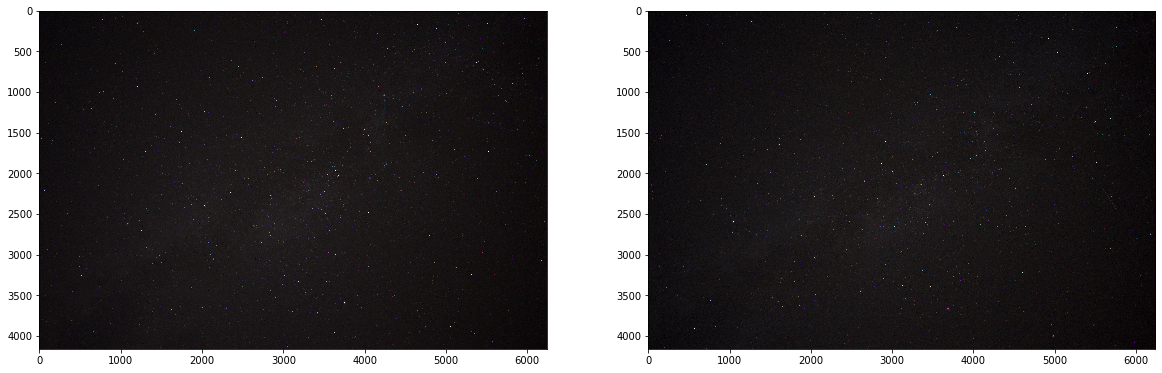

In [19]:
fig = plt.figure(figsize=(20,20))
for i,image in enumerate(images):
    fig.add_subplot(len(images)//2, 2, i+1)
    plt.imshow(image)

So there are all of our raw images of the sky, taken at slightly different times. Let's add them together.

In [22]:
main, *others = images
(stacked, count) = add(main, ((lambda:img) for img in others))

`stacked` contains the stacked image. `count` tells us what percent of source images contributed to the final result.

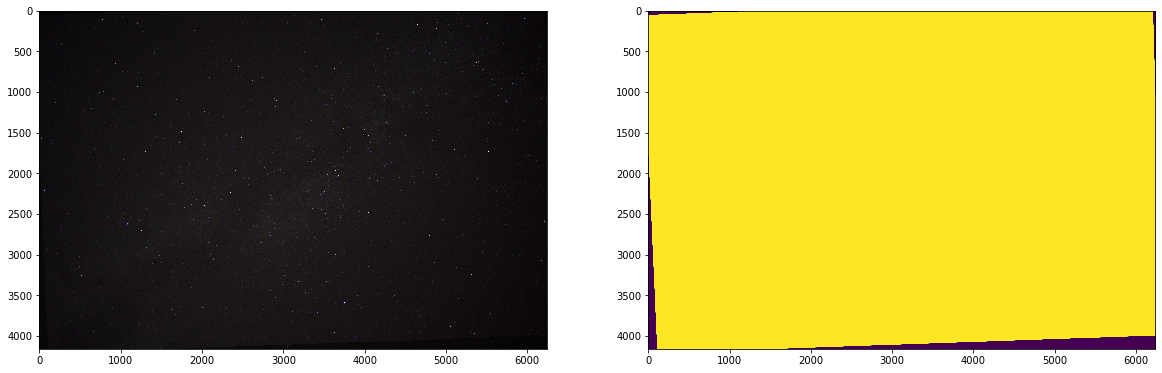

In [24]:
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.imshow(stacked)
fig.add_subplot(1, 2, 2)
plt.imshow(count)

The yellow region of `count` indicates where 100% of source images were used.

Let's crop out a section of the stacked image so that its data is taken from every source image.

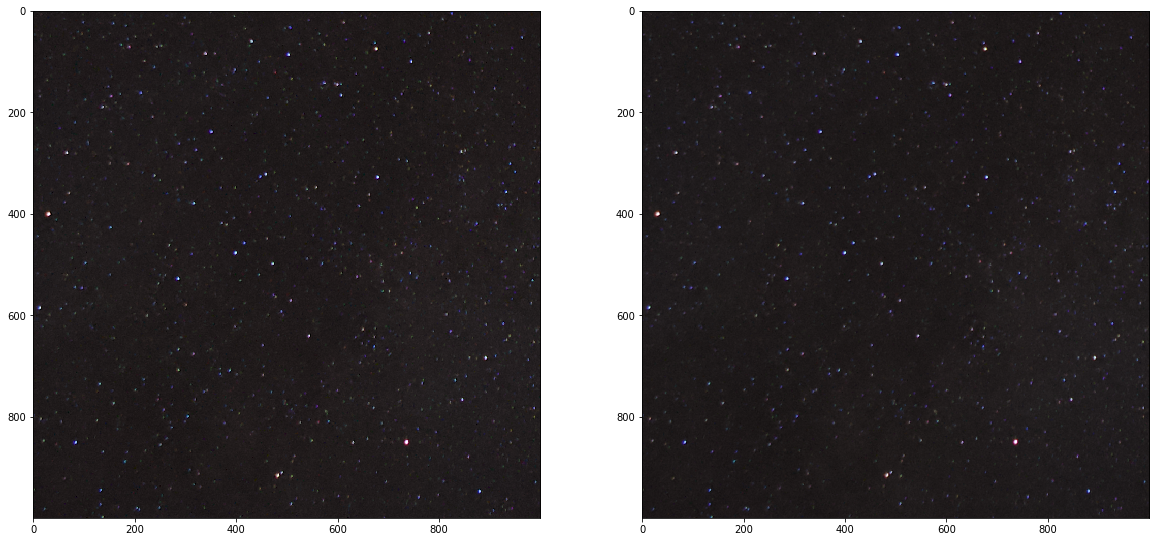

In [32]:
def crop(img):
    return img[2000:3000,2000:3000]
# double check that our cropped out region uses 100% of source images
assert((crop(count)==1.0).all()) 
original = crop(main)
new = crop(stacked)
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.imshow(original)
fig.add_subplot(1, 2, 2)
plt.imshow(new)

As you can (maybe) see, the second image is the same as the first image, but with less noise. In case you can't visually see the noise difference, let's do a little comparison:

In [133]:
def quick_rundown(bog,w,width,fig):
    (x,y,chs) = bog.shape
    num_plots = 4
    indices = ((i*width)+w+1 for i in range(num_plots))
    subplots = (fig.add_subplot(num_plots,width,i) for i in indices)
    # The image itself
    original = subplots.__next__()
    original.set_title('image')
    original.imshow(bog)
    # channel intensity distributions
    distribution = subplots.__next__()
    distribution.set_title('per-channel intensity distribution')
    logdist = subplots.__next__()
    logdist.set_yscale('log')
    logdist.set_title('per-channel intensity distribution, log')
    noisedist = subplots.__next__()
    noisedist.set_yscale('log')
    noisedist.set_title('per-channel intensity distribution, log, 0.075-0.175')
    for (i,color) in enumerate("rgb"[:chs]):
        counts,axis = np.histogram(bog[:,:,i],bins=1000)
        axis = axis[1:]
        distribution.plot(axis,counts,color)
        logdist.plot(axis,counts,color)
        noisedist.plot(axis[75:175],counts[75:175],color)
def quick_rundowns(bogs):
    width = len(bogs)
    fig = plt.figure(figsize=(15,40))
    for (w,img) in enumerate(bogs):
        quick_rundown(img,w,width,fig)

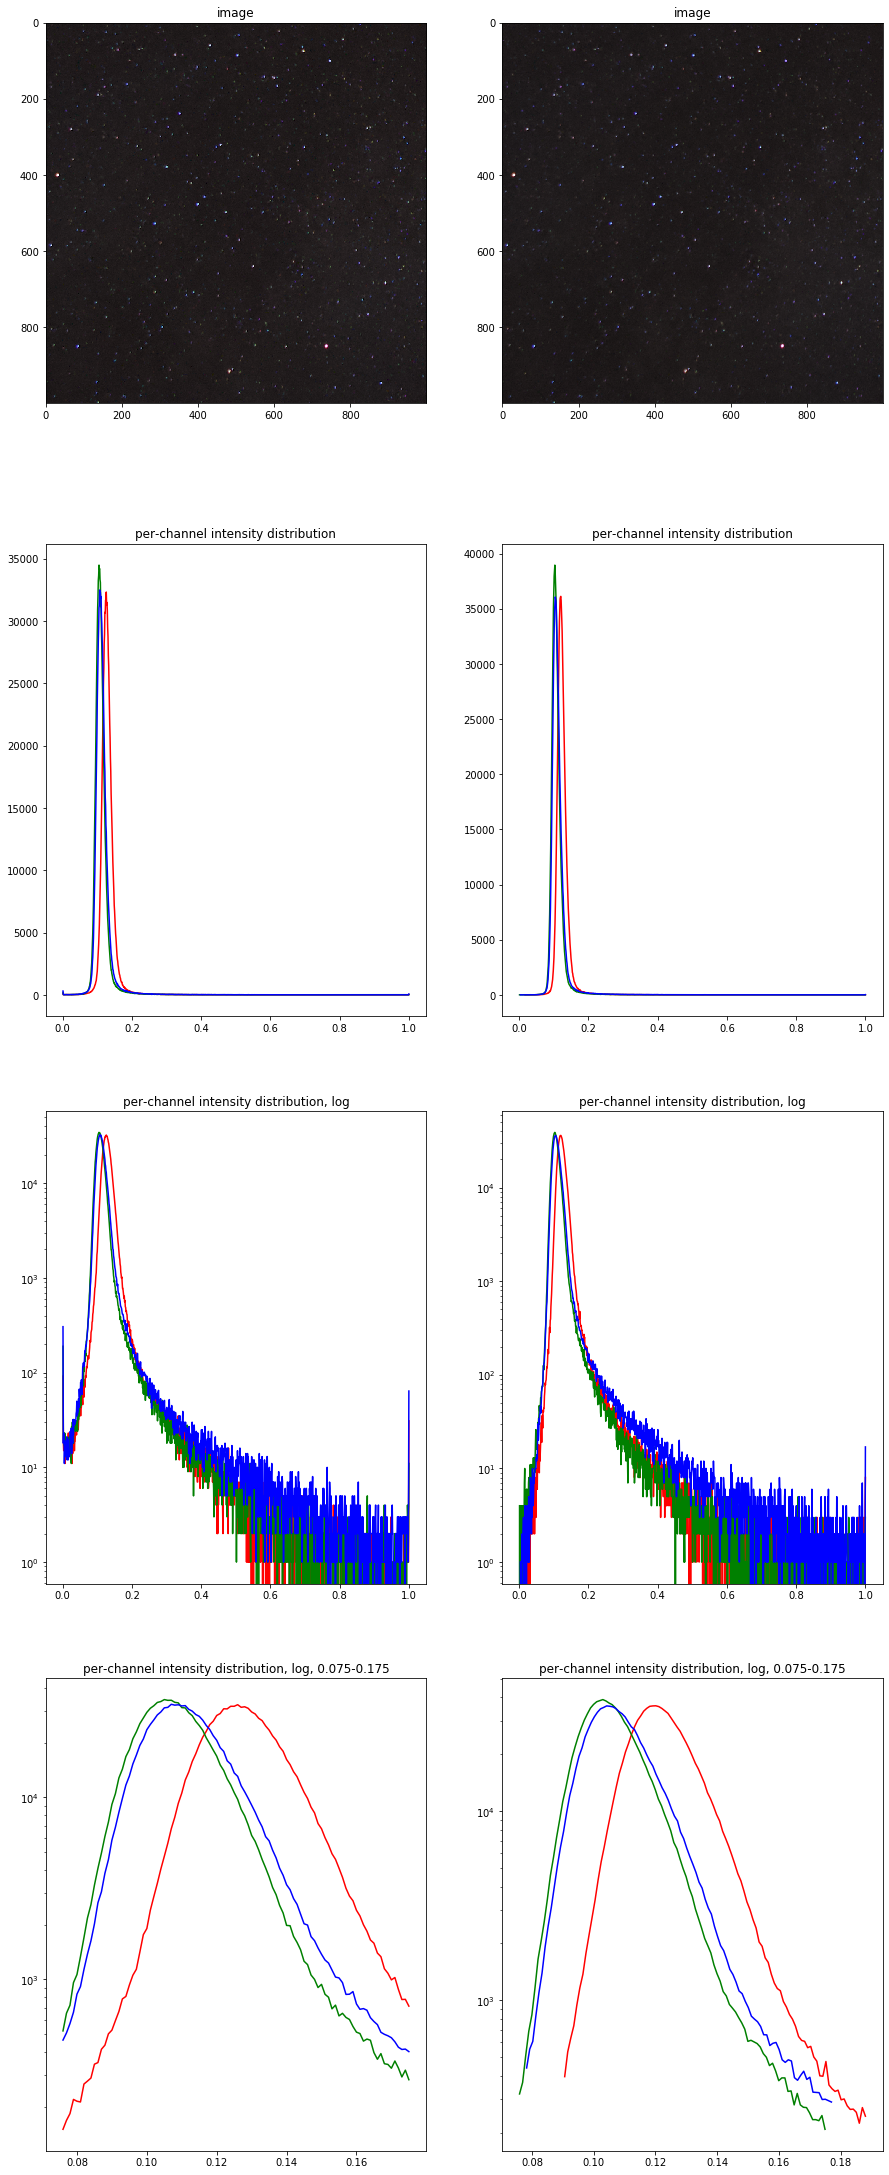

In [134]:
quick_rundowns([original,new])

Let's talk a bit about *why* stacking reduces noise. 

First, let's create a test image:

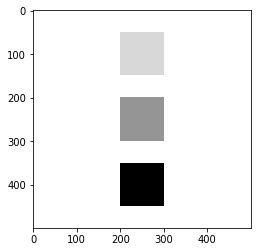

In [63]:
image = np.zeros((500,500),dtype='float')
image[50:150,200:300] = 0.25
image[200:300,200:300] = 0.5
image[350:450,200:300] = 1
plt.imshow(image, cmap='Greys')

Let's add a bunch of noise to this image, so we can barely see what's going on.

We're going to use gaussian noise. Almost all of the physical processes that create noise in a photograph are actually poisson processes, meaning that the noise follows a poisson distribution. However, with lots of samples, a poisson distribution becomes extremely close to a gaussian distribution. Since consumer cameras always sample large numbers of photons, we can pretend our noise sources are gaussian. Many articles on camera noise just call the noise "gaussian" outright, even though it's not quite correct.

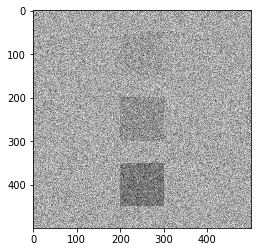

In [84]:
mean = 0.3
def make_noise():
    return np.random.normal(loc=mean,scale=np.sqrt(mean), size=(500,500))
plt.imshow(image + make_noise(), cmap='Greys')

As you can see, the light-grey square has become almost invisible, and the darker two squares are heavily degraded.

Now, you might intuitively expect that adding up lots of noisy images will produce yet another noisy image, but something interesting happens if we add up large numbers of noisy images of the same subject.

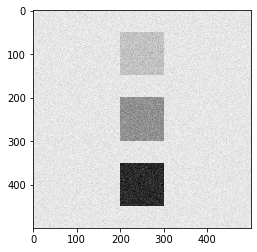

In [85]:
noisy_images = [image + make_noise() for _ in range(100)]
summed_image = np.sum(noisy_images,axis=0)/100
plt.imshow(summed_image, cmap='Greys')

The sum of lots of noisy images is *vastly* higher quality than any individual noisy image. What happened?

The answer lies generally in the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), and more specifically in the [behavior of normal distributions](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables).

To illustrate why this happens intuitively, imagine that you have a 1-pixel camera, which meausures light values from 0 to 1. The true light value of your subject is 0.5. Imagine also that you have only a single noise source, which will randomly either add or subtract 0.01 from your measured light value.

If you only take a single photo, your photograph will have a value of either 0.49 or 0.51 (the true value of the subject, plus the random error).

If you take two photos, sum them up, and divide them by two, the photograph will have a value of 0.49, 0.5, or 0.51. There are four cases:

1. negative, negative -> 0.98/2 = 0.49
2. negative, positive -> 1/2 = 0.5
3. positive, negative -> 1/2 = 0.5
4. positive, positive -> 1.02/2 = 0.51

Let's write some code to enumerate all the possible cases for `n` photos, if we were to stack them

In [122]:
def possible_values_of_n_shots(n):
    if n == 0: # no photos taken
        yield 0
    else:
        for possible_value in possible_values_of_n_shots(n-1):
            yield possible_value + 0.51 # our error is positive
            yield possible_value + 0.49 # our error is negative

def possible_values_of_n_shots_averaged(n):
    for possible_value in possible_values_of_n_shots(n):
        yield possible_value/n

print(list(possible_values_of_n_shots_averaged(1)))
print(list(possible_values_of_n_shots_averaged(2)))


[0.51, 0.49]
[0.51, 0.5, 0.5, 0.49]


Let's plot the distribution of values for different values of `n`.

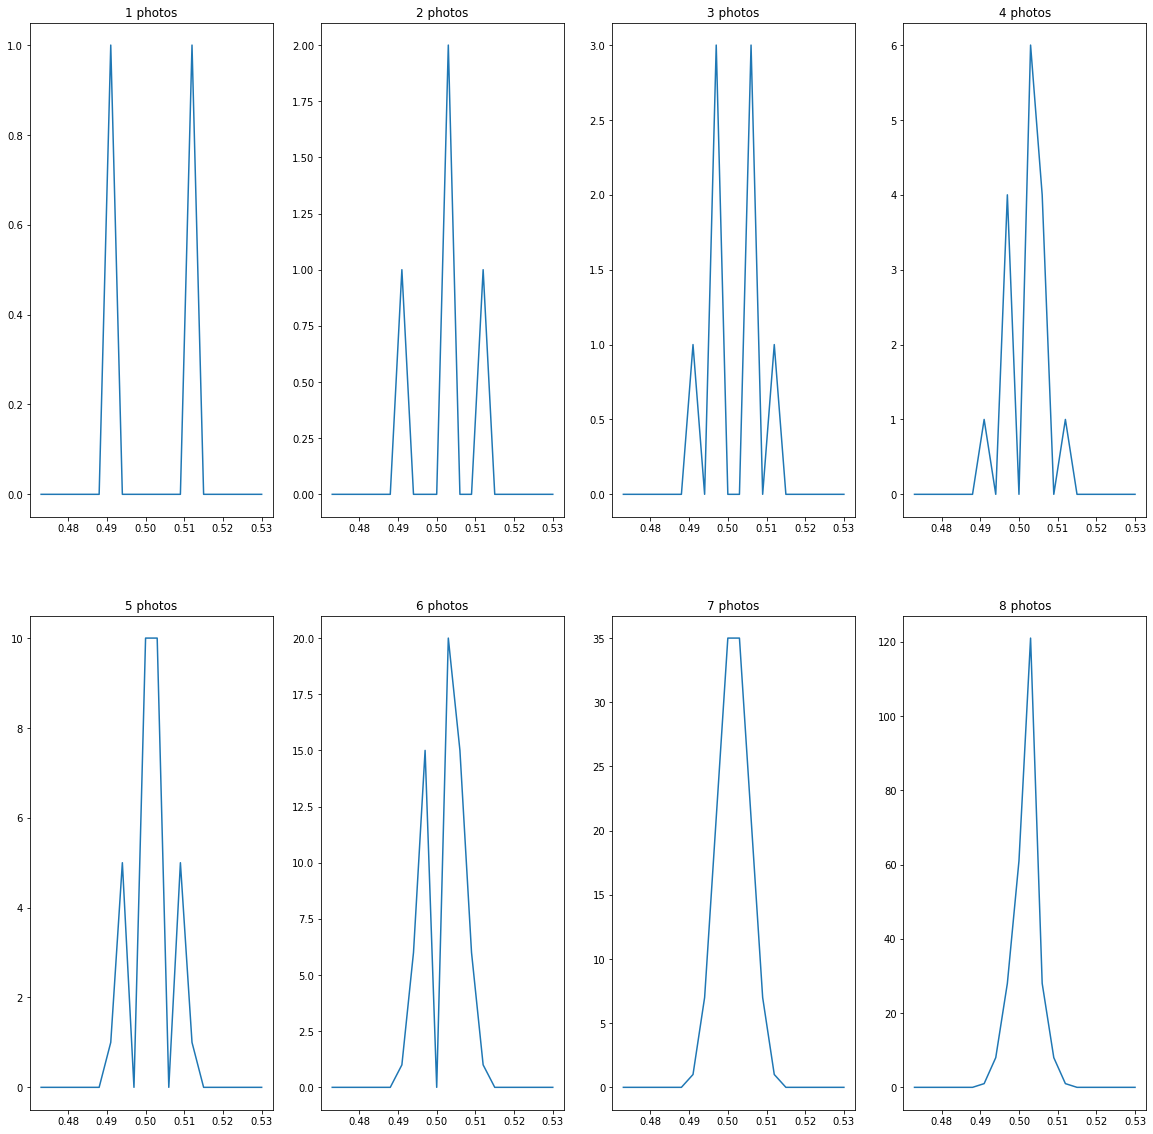

In [121]:
fig = plt.figure(figsize=(20,20))

def plot(n):
    photos = list(possible_values_of_n_shots_averaged(n))
    (histogram,axis) = np.histogram(photos, bins=20, range=(0.47,0.53))
    plt.plot(axis[1:],histogram)
    
for n in range(1,9):
    fig.add_subplot(2, 4, n,title=("%i photos" % n))
    plot(n)

As you can see, as we take more photos and average them out, it's way more likely that the measured brightness is close to the true value (0.5).

This is the result of two facts:

1. As you take a lot of photos, there's a pretty good chance that the errors in different photos will cancel each other out. You'd have to get really unlucky for the error to be in the same direction every time. 
2. Let's say we got super unlucky and had positive error every time. If we took N photos, our measurement error is `(0.01*N)/N = 0.01`. So *the worst case error is the same as the error for a single photo*. However, since most of the time our errors cancel out to some degree, we usually get a much lower error than if we took a single photo.

Now, this is a pretty idealized example, because A) the error follows a very simple distribution and B) the error averages to zero.

A somewhat more realistic model would be if our error in each photo followed, say, a normal distribution (like in the test image with the squares) with average `x` and standard deviation `sqrt(x)`.

In that case, if we were to take `N` images and add them up, the average error would be `x*N` and the standard deviation (basically, how wide a range of error values you expect) would be `sqrt(x*N) = sqrt(x)*sqrt(N)`. After averaging out the images by dividing the sum by `N`, the average error would still be `x`, but the standard deviation would be `sqrt(x)*sqrt(N)/N = sqrt(x)/sqrt(N)`. In other words, the deviation of our error decreases by a factor of the square root of the number of pictures we take. So if we take 100 pictures, the standard deviation of our error decreases by 10 times.

This isn't *quite* ideal, because there's still an average error of `x` being added to each pixel. However, since the error on each pixel is now much more uniform, we can do things like subtract `x` from each pixel and expect to get a pretty reasonable result.